# Playlist Neural Network

Given a list of playlists, can unknown tracks be correctly classified?

In [216]:
# playlist_names = ["RAP", "EDM", "ROCK", "METAL", "JAZZ", "POP"] # super-genres
# playlist_names = ["ALL RAP", "EDM", "ROCK", "METAL", "JAZZ", "POP"] # super-genres
# playlist_names = ["RAP", "EDM", "ROCK", "METAL", "JAZZ"] # super-genres without POP
playlist_names = ["ALL RAP", "EDM", "ROCK", "METAL", "JAZZ"] # super-genres without POP
# playlist_names = ["DNB", "HOUSE", "TECHNO", "GARAGE", "DUBSTEP", "BASS"] # EDM playlists
# playlist_names = ["20s rap", "10s rap", "00s rap", "90s rap", "80s rap"] # rap decades
# playlist_names = ["UK RAP", "US RAP"] # UK/US split
# playlist_names = ["uk rap", "grime", "drill", "afro bash"] # british rap playlists
# playlist_names = ["20s rap", "10s rap", "00s rap", "90s rap", "80s rap", "trap", "gangsta rap", "industrial rap", "weird rap", "jazz rap", "boom bap", "trap metal"] # american rap playlists
# playlist_names = ["rock", "indie", "punk", "pop rock", "bluesy rock", "hard rock", "chilled rock", "emo", "pop punk", "stoner rock/metal", "post-hardcore", "melodic hardcore", "art rock", "post-rock", "classic pop punk", "90s rock & grunge", "90s indie & britpop", "psych"] # rock playlists
# playlist_names = ["metal", "metalcore", "mathcore", "hardcore", "black metal", "death metal", "doom metal", "sludge metal", "classic metal", "industrial", "nu metal", "calm metal", "thrash metal"] # metal playlists

# headers = float_headers + ["duration_ms", "mode", "loudness", "tempo"]
headers = float_headers

BALANCED_WEIGHTS = True

Pull and process playlist information.

1. Get live playlist track information from spotify
2. Filter listening history for these tracks

Filter out tracks without features and drop duplicates before taking only the descriptor parameters

In [217]:
playlists = [get_playlist(i, spotnet) for i in playlist_names] # 1)

# filter playlists by join with playlist track/artist names
filtered_playlists = [pd.merge(track_frame(i.tracks), scrobbles, on=['track', 'artist']) for i in playlists] # 2)

filtered_playlists = [i[pd.notnull(i["uri"])] for i in filtered_playlists]
# distinct on uri
filtered_playlists = [i.drop_duplicates(['uri']) for i in filtered_playlists]
# select only descriptor float columns
filtered_playlists = [i.loc[:, headers] for i in filtered_playlists]

Construct the dataset with associated labels before splitting into a train and test set.

In [218]:
dataset = pd.concat(filtered_playlists)
labels = [np.full(len(plst), idx) for idx, plst in enumerate(filtered_playlists)]
labels = np.concatenate(labels)

# stratify: maintains class proportions in test and train set
data_train, data_test, labels_train, labels_test = train_test_split(dataset, labels, 
                                                                    test_size=0.1, 
#                                                                     random_state=70, 
                                                                    stratify=labels
                                                                   )

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(labels_train),
                                                  y=labels_train)
class_weights = {i: j for i, j in zip(range(len(filtered_playlists)), class_weights)}

labels_train = tf.one_hot(labels_train, len(filtered_playlists))
labels_test = tf.one_hot(labels_test, len(filtered_playlists))

In [219]:
def tensorboard_callback(path='tensorboard-logs', prefix=''):
    return tf.keras.callbacks.TensorBoard(
        log_dir=os.path.normpath(os.path.join(path, prefix + datetime.now().strftime("%Y%m%d-%H%M%S"))), histogram_freq=1
    )

In [220]:
def get_model(hidden_nodes=9,
              layers=1,
              classes=len(filtered_playlists),
              activation=lambda: 'sigmoid', 
              weight_init=lambda: 'glorot_uniform'):
    l = [tf.keras.layers.InputLayer(input_shape=data_train.to_numpy()[0].shape, name='Input')]
    
    for i in range(layers):
        l.append(
            tf.keras.layers.Dense(hidden_nodes, 
                                  activation=activation(), 
                                  kernel_initializer=weight_init(), 
                                  name=f'Hidden{i+1}')
        )
    
    l.append(tf.keras.layers.Dense(classes, 
                                   activation='softmax', 
                                   kernel_initializer=weight_init(), 
                                   name='Output'))
    
    model = tf.keras.models.Sequential(l)
    return model

# Single Model

In [226]:
model = get_model(hidden_nodes=64, layers=2)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
#               optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden1 (Dense)              (None, 64)                512       
_________________________________________________________________
Hidden2 (Dense)              (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 5)                 325       
Total params: 4,997
Trainable params: 4,997
Non-trainable params: 0
_________________________________________________________________


## Train

In [227]:
if BALANCED_WEIGHTS:
    cw = class_weights
else:
    cw = None
history = model.fit(data_train.to_numpy(), labels_train, 
                    callbacks=[tensorboard_callback()], 
                    validation_split=0.11,
                    verbose=0,
                    class_weight=cw,
                    epochs=50)

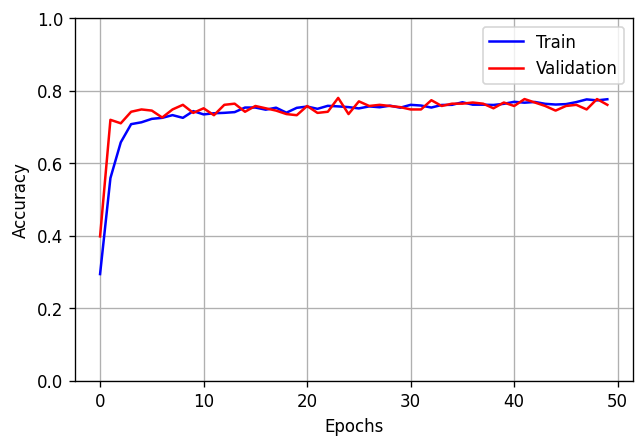

In [228]:
history.history
plt.plot(range(len(history.history["accuracy"])), history.history["accuracy"], label="Train", c=(0, 0, 1))
plt.plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Validation", c=(1, 0, 0))

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)

plt.grid()
plt.legend()
plt.show()

## Test

Single number below from the evaluate function

In [229]:
model.evaluate(data_test.to_numpy(), labels_test)

10/10 [==============================] - 0s 857us/step - loss: 0.6952 - accuracy: 0.7792


[0.6951839327812195, 0.7791798114776611]

Get raw predictions from test data to generate a confusion matrix

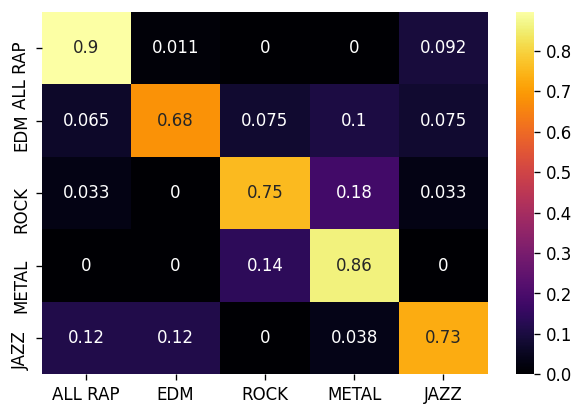

In [230]:
predictions = model(data_test.to_numpy())

conf = tf.math.confusion_matrix([tf.math.argmax(i) for i in labels_test], 
                                [tf.math.argmax(i) for i in predictions], 
                                num_classes=len(filtered_playlists))

normalised_conf = np.ndarray((len(filtered_playlists), len(filtered_playlists)))
for idx, row in enumerate(conf):
    normalised_conf[idx, :] = row / np.sum(row)

sns.heatmap(normalised_conf, 
            annot=True, 
            xticklabels=playlist_names, yticklabels=playlist_names, 
            cmap='inferno')
plt.show()

# Imports & Setup

In [60]:
from datetime import datetime
import os

from google.cloud import bigquery
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import seaborn as sns

from analysis.net import get_spotnet, get_playlist, track_frame
from analysis.query import *
from analysis import spotify_descriptor_headers, float_headers, days_since

import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf

client = bigquery.Client()
spotnet = get_spotnet()
cache = 'query.csv'
first_day = datetime(year=2017, month=11, day=3)
sig_max, c_max = 0.5, 20

## Read Scrobble Frame

In [2]:
scrobbles = get_query(cache=cache)

## Write Scrobble Frame

In [6]:
scrobbles.reset_index().to_csv(cache, sep='\t')